# Exploratory Data Analysis on the Film industry

# Business Understanding

Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

# Data Understanding

The data was collected from various locations, the different files have different formats.
* [Box Office Mojo](https://www.boxofficemojo.com/)
* [IMDB](https://www.imdb.com/)
* [Rotten Tomatoes](https://www.rottentomatoes.com/)
* [TheMovieDB](https://www.themoviedb.org/)
* [The Numbers](https://www.the-numbers.com/)

Some are compressed CSV (comma-separated values) or TSV (tab-separated values), while the data from IMDB is located in a SQLite database.

<img alt='IMDB data erd' src='/movie_data_erd.jpeg' width='500px'/>


# Data Preparation

## Loading the data

In [1]:
# Importing modules
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

%matplotlib inline

In [2]:
# create a connection to sqlite3
conn = sqlite3.connect('zippedData/im.db')

In [3]:
# loading the data
bom_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
rt_movie_info_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter='\t')
rt_reviews_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter='\t', encoding='latin-1')
tmdb_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')
tn_budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

## Box Office Mojo

In [4]:
bom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


The data has 3397 entries with some data missing in some columns( studio, domestic_gross and foreign_gross).

There are 5 columns

Also the foreign gross is in string format

### (a). cleaning 'foreign_gross' column

In [5]:
bom_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


We start off by converting the foreign_gross column to numeric data type(float64)

In [6]:
# first eliminate commas
bom_df['foreign_gross'] = bom_df.foreign_gross.map(
    lambda x: "".join(x.split(',')) if type(x) == str else x
)
bom_df['foreign_gross'] = bom_df.foreign_gross.astype(float)

bom_df.foreign_gross.dtype

dtype('float64')

Now that the column is in the correct format we can handle the missing values. 

'**The Numbers**' dataset contains budgets for some movies. We can first check some of the missing entries in the dataset.

In [7]:
# The numbers dataset
tn_budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [8]:
tn_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


no missing entries present

We start by cleaning the numeric columns to eliminate dollar sings and commas

In [9]:
def clean_money_cols(row):
    """Function to clean money columns in the tn_budgets df"""
    i = 3
    cols = ['production_budget', 'domestic_gross',	'worldwide_gross']
    while i < len(row):
        value = row[cols[i - 3]]
        if isinstance(value, str) and value.startswith('$'):
            # remove dollar sign
            value = value[1:]
            # eliminate the commas
            value = float(value.replace(',', ''))
        row[cols[i - 3]] = value
        # increment count
        i += 1
    return row

tn_budgets_df = tn_budgets_df.apply(
    lambda row: clean_money_cols(row), axis=1
)

Now that the amounts columns are in the right data type, we can add another column for foreign gross

> foreign_gross = worldwide_gross - domestic_gross

In [10]:
# creating new column for foreign gross
tn_budgets_df['foreign_gross'] = (
    tn_budgets_df.worldwide_gross - tn_budgets_df.domestic_gross
)
tn_budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,foreign_gross
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,2.015838e+09
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,8.046000e+08
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,1.070000e+08
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,9.440081e+08
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,6.965404e+08


Fetching all the movies with missing foreign_gross

In [11]:
missing_foreign_gross = bom_df.loc[
    bom_df.foreign_gross.isna(),
    'title'
]

print('Movies missing foreign gross:', len(missing_foreign_gross))

Movies missing foreign gross: 1350


Now we try to get the foreign gross in the tn_budgets_df data

In [12]:
new_foreign_gross = tn_budgets_df.loc[
    tn_budgets_df.movie.isin(missing_foreign_gross),
    ['movie', 'foreign_gross']
]

# change columns to change movie to title
new_foreign_gross.columns = ['title', 'foreign_gross']

print(' Foreign gross entries found in "The Numbers" data:',
      len(new_foreign_gross))

new_foreign_gross.head()

 Foreign gross entries found in "The Numbers" data: 161


,title,foreign_gross
588,Evolution,60030798.0
946,Rock Dog,14727942.0
1041,Bullet to the Head,13108140.0
1231,The Infiltrator,5281296.0
1290,All Eyez on Me,9954553.0


Found 161 of the missing values in the other dataframe. We now fill in the values in the bom dataframe

First we check if there are 0's in the new values which also indicate missing values and remove them

In [13]:
new_foreign_gross = new_foreign_gross.loc[
    new_foreign_gross.foreign_gross != 0
]

len(new_foreign_gross)

151

Down to 151. we now fill them in the dataframe

we start by defining a helper function

In [14]:
def fill_foreign_gross(row):
    """function to fill the foreign gross column"""
    if row.title in list(new_foreign_gross.title):
        row.foreign_gross = float(
            new_foreign_gross.loc[
                new_foreign_gross.title == row.title,
                'foreign_gross'
            ].values[0]
        )
    return row

filling the values

In [15]:
bom_df = bom_df.apply(
    lambda row: fill_foreign_gross(row),
    axis=1
)

In [16]:
bom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2187 non-null   float64
 4   year            3387 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 132.4+ KB


for the remaining missing values we can fill with the mean foreign gross

In [17]:
# Handling the remaining missing values in the foreign_gross
foreign_mean = bom_df.foreign_gross.mean()

bom_df.foreign_gross.fillna(foreign_mean, inplace=True)

# check for missing values
bom_df.foreign_gross.isna().sum()

0

**Creating new column for worldwide gross**

In [18]:
# create new column for worldwide gross
bom_df['worldwide_gross'] = (
    bom_df.foreign_gross + bom_df.domestic_gross
)

bom_df.columns

Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year',
       'worldwide_gross'],
      dtype='object')

### (b). Handling missing data in domestic_gross column

We do the same for the domestic column, first try to get the missing values in the other dataframe, then fill with the mean

In [19]:
# Get the missing entries in the domestic gross columns
missing_domestic_gross = bom_df.loc[
    bom_df.domestic_gross.isna(),
    'title'
]

print('Movies missing domestic gross:', len(missing_domestic_gross))

Movies missing domestic gross: 28


In [20]:
new_domestic_gross = tn_budgets_df.loc[
    tn_budgets_df.movie.isin(missing_domestic_gross),
    ['movie', 'domestic_gross']
]

# change columns to change movie to title
new_domestic_gross.columns = ['title', 'domestic_gross']

print('domestic gross entries found in "The Numbers" data:',
      len(new_domestic_gross))

new_domestic_gross.head()

domestic gross entries found in "The Numbers" data: 2


,title,domestic_gross
3735,It's a Wonderful Afterlife,0.0
5382,All the Boys Love Mandy Lane,0.0


We found two of the movies missing the domestic gross but its still 0 meaning that its also missing in the other data source.

Therefore we replace the missing values with mean

In [21]:
# get the mean
domestic_mean = bom_df.domestic_gross.mean()

# fill the null values with mean
bom_df['domestic_gross'] = bom_df.domestic_gross.fillna(domestic_mean)

bom_df.domestic_gross.isna().sum()

0

no more missing values in the domestic gross column

In [22]:
bom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            3387 non-null   object 
 1   studio           3382 non-null   object 
 2   domestic_gross   3387 non-null   float64
 3   foreign_gross    3387 non-null   float64
 4   year             3387 non-null   int64  
 5   worldwide_gross  3359 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 158.9+ KB


The studio column has 5 missing entries

In [23]:
bom_df.studio.fillna('missing', inplace=True)

bom_df.studio.isna().sum()

0


We are now done cleaning The Box office mojo.

## IMDB

The data is in form of a sqlite database

we first check the available tables

In [24]:
table_q = """
SELECT name 
FROM sqlite_master 
WHERE type='table';
"""

pd.read_sql(table_q, conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


### 1. movie_basics

In [25]:
mb_query = """
SELECT *
FROM movie_basics
"""
movie_basics = pd.read_sql(mb_query, conn)


movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


This table contains the basic information about the movies eg title, and genre

In [26]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


We notice missing data in some columns. 

Lets start with the original_title column. Since there are few entries missing, we fill with the tag 'missing'

#### (a). original_title column

In [27]:
movie_basics.original_title.fillna('missing', inplace=True)

movie_basics.original_title.isna().sum()

0

#### (b). runtime_minutes column

For runtime_minutes, we can fill with the average

In [28]:
# get the mean runtime minutes
mean_runtime = movie_basics.runtime_minutes.mean()
movie_basics.runtime_minutes.fillna(mean_runtime, inplace=True)

movie_basics.runtime_minutes.isna().sum()

0

#### (c). genres column

For genres column we can try to get the missing genres in different datasets. But first we obtain the movies with missing genres

In [29]:
# movies with missing genres
missing_genres_df = movie_basics.loc[
    movie_basics['genres'].isna()
]

missing_genres_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
16,tt0187902,How Huang Fei-hong Rescued the Orphan from the...,How Huang Fei-hong Rescued the Orphan from the...,2011,86.187247,None
22,tt0253093,Gangavataran,Gangavataran,2018,134.000000,None
35,tt0306058,Second Coming,Second Coming,2012,95.000000,None
40,tt0326592,The Overnight,The Overnight,2010,88.000000,None
44,tt0330811,Regret Not Speaking,Regret Not Speaking,2011,86.187247,None


We only need the title and the id

In [30]:
missing_genres_df = missing_genres_df.loc[
    :, ['movie_id', 'primary_title', 'original_title']
]

missing_genres_df.head()

,movie_id,primary_title,original_title
16,tt0187902,How Huang Fei-hong Rescued the Orphan from the...,How Huang Fei-hong Rescued the Orphan from the...
22,tt0253093,Gangavataran,Gangavataran
35,tt0306058,Second Coming,Second Coming
40,tt0326592,The Overnight,The Overnight
44,tt0330811,Regret Not Speaking,Regret Not Speaking


Lets start with the **Rotten tomatoes** data and check if it contains a genres column

In [31]:
rt_movie_info_df.columns

Index(['id', 'synopsis', 'rating', 'genre', 'director', 'writer',
       'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime',
       'studio'],
      dtype='object')

In [32]:
rt_movie_info_df.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


We can use the  'genre' column but there is no title column to compare to the data in missing_genres_df

Lets check **The Movie Db data** 

In [33]:
tmdb_df.columns

Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')

In [34]:
tmdb_df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


For this data, there is a title column to compare to, but the genres are id refferencing to a genres table which we dont have access to.



Finally **The Numbers** data

In [35]:
tn_budgets_df.columns

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'foreign_gross'],
      dtype='object')

There is no column we can use to get the genres

Since we cant get the genres from the other data sources, we can fill the entries with 'missing' tag

In [36]:
movie_basics.fillna('missing', inplace=True)

movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146144 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  146144 non-null  float64
 5   genres           146144 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


There are no more missing values in the data.



Checking for duplicates

In [49]:
movie_basics.duplicated().sum()

0

No duplicates.

We completed cleaning the movie basics table.

### 2. movie_ratings

In [42]:
mr_query = """
SELECT *
FROM movie_ratings
"""

movie_ratings = pd.read_sql(mr_query, conn)
movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [50]:
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


no missing values in the ratings table

Checking for duplicates

In [51]:
movie_ratings.duplicated().sum()

0

no duplicates in the movie ratings table

### 3. Genre ratings

In [52]:

movie_basics.genres.value_counts()

Documentary                32185
Drama                      21486
Comedy                      9177
missing                     5408
Horror                      4372
                           ...  
Comedy,History,Thriller        1
Horror,Sci-Fi,War              1
Animation,Family,Sport         1
Documentary,Musical,War        1
Comedy,Sci-Fi,Western          1
Name: genres, Length: 1086, dtype: int64

 In a single entry, some genres are merged and separated by commas. We start with a fresh df, divide each category, and make sure it has its own row.

Join movie basics and movie ratings

In [53]:
merged_ratings = movie_ratings.merge(movie_basics, on='movie_id', how='inner')

In [54]:
# create df as copy of ratings df
genre_df = merged_ratings.copy()

# split the genres
genre_df['genres'] = genre_df.genres.str.split(',')

# one genre in each row
genre_df = genre_df.explode('genres')

genre_df.head()

,movie_id,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres
0,tt10356526,8.3,31,Laiye Je Yaarian,Laiye Je Yaarian,2019,117.0,Romance
1,tt10384606,8.9,559,Borderless,Borderless,2019,87.0,Documentary
2,tt1042974,6.4,20,Just Inès,Just Inès,2010,90.0,Drama
3,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,Action
3,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,Adventure


In [55]:
genre_df.genres.value_counts().index

Index(['Drama', 'Documentary', 'Comedy', 'Thriller', 'Horror', 'Action',
       'Romance', 'Crime', 'Adventure', 'Biography', 'Family', 'Mystery',
       'History', 'Sci-Fi', 'Fantasy', 'Music', 'Animation', 'Sport', 'War',
       'missing', 'Musical', 'News', 'Western', 'Reality-TV', 'Adult',
       'Game-Show', 'Short'],
      dtype='object')

### 4. Directors

In [57]:
dir_query = """
SELECT  *
FROM 
    directors d
JOIN
    persons p
USING(person_id)
"""

directors = pd.read_sql(dir_query, conn)
directors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291171 entries, 0 to 291170
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movie_id            291171 non-null  object 
 1   person_id           291171 non-null  object 
 2   primary_name        291171 non-null  object 
 3   birth_year          68608 non-null   float64
 4   death_year          1738 non-null    float64
 5   primary_profession  290187 non-null  object 
dtypes: float64(2), object(4)
memory usage: 13.3+ MB


the birth_year, death_year and primary_profession columns have missing values.

we use 0 inplace of the missing values

In [58]:
# handle missing birth year
directors['birth_year'].fillna(0, inplace=True)

# handle missing death year
directors['death_year'].fillna(0, inplace=True)

directors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291171 entries, 0 to 291170
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movie_id            291171 non-null  object 
 1   person_id           291171 non-null  object 
 2   primary_name        291171 non-null  object 
 3   birth_year          291171 non-null  float64
 4   death_year          291171 non-null  float64
 5   primary_profession  290187 non-null  object 
dtypes: float64(2), object(4)
memory usage: 13.3+ MB


The primary_profession is the only column with missing values.


In [59]:
directors['primary_profession'].fillna('director', inplace=True)

directors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291171 entries, 0 to 291170
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movie_id            291171 non-null  object 
 1   person_id           291171 non-null  object 
 2   primary_name        291171 non-null  object 
 3   birth_year          291171 non-null  float64
 4   death_year          291171 non-null  float64
 5   primary_profession  291171 non-null  object 
dtypes: float64(2), object(4)
memory usage: 13.3+ MB


checking for duplicates

In [60]:
directors.duplicated().sum()

127638

The  table contains many duplicates

In [61]:
directors.drop_duplicates(inplace=True)

directors.duplicated().sum()

0

### 5. Writers

In [65]:
wr_query = """
SELECT*
FROM
    writers w
JOIN
    persons p
USING(person_id)
"""

writers = pd.read_sql(wr_query, conn)
writers.head()

,movie_id,person_id,primary_name,birth_year,death_year,primary_profession
0,tt0285252,nm0899854,Tony Vitale,1964.0,NaN,"producer,director,writer"
1,tt0438973,nm0175726,Steve Conrad,1968.0,NaN,"writer,producer,director"
2,tt0438973,nm1802864,Sean Sorensen,NaN,NaN,"producer,writer"
3,tt0462036,nm1940585,Bill Haley,NaN,NaN,"director,writer,producer"
4,tt0835418,nm0310087,Peter Gaulke,NaN,NaN,"writer,actor,director"


In [64]:
writers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255871 entries, 0 to 255870
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movie_id            255871 non-null  object 
 1   person_id           255871 non-null  object 
 2   primary_name        255871 non-null  object 
 3   birth_year          52917 non-null   float64
 4   death_year          4078 non-null    float64
 5   primary_profession  255029 non-null  object 
dtypes: float64(2), object(4)
memory usage: 11.7+ MB


Similar columns as in directors table are missing in the writer table.


In [66]:
# Filling the birth column
writers['birth_year'].fillna(0, inplace=True)

# filling the death column
writers['death_year'].fillna(0, inplace=True)

# filling the primary proffession column
writers['primary_profession'].fillna('writer', inplace=True)

writers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255871 entries, 0 to 255870
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movie_id            255871 non-null  object 
 1   person_id           255871 non-null  object 
 2   primary_name        255871 non-null  object 
 3   birth_year          255871 non-null  float64
 4   death_year          255871 non-null  float64
 5   primary_profession  255871 non-null  object 
dtypes: float64(2), object(4)
memory usage: 11.7+ MB


No more missing values in this table.

Checking for duplicates

In [67]:
# check duplicates
writers.duplicated().sum()

77521

the table has many duplicates, hence we drop them

In [68]:
writers.drop_duplicates(inplace=True)

# check duplicates
writers.duplicated().sum()

0

# Data Analysis

In [69]:
# suppressing scientific notation
pd.options.display.float_format = '{:.0f}'.format

## 1. Best income generating studios

We use the Box Office Mojo data

In [70]:
bom_df.head()

,title,studio,domestic_gross,foreign_gross,year,worldwide_gross
0,Toy Story 3,BV,415000000,652000000,2010,1067000000
1,Alice in Wonderland (2010),BV,334200000,691300000,2010,1025500000
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000,664300000,2010,960300000
3,Inception,WB,292600000,535700000,2010,828300000
4,Shrek Forever After,P/DW,238700000,513900000,2010,752600000


### (a). summary statistics

In [71]:
bom_summary = bom_df.loc[
    :,
    ['domestic_gross', 'foreign_gross', 'worldwide_gross']
].describe()
bom_summary

,domestic_gross,foreign_gross,worldwide_gross
count,3387,3387,3359
mean,28745845,70151173,99363294
std,66704973,107498910,163424096
min,100,600,4900
25%,122500,8000000,18200000
50%,1400000,70151173,70187773
75%,28745845,70151173,73351173
max,936700000,960500000,1518900000


The mean earnings for the movies are around:
- $\$$ 28M for Domestic gross
- $\$$ 70M for Foreign gross
- $\$$ 99M for worldwide gross

The earnings for the movies range from:
- $\$$ 100 to $\$$ 936M for Domestic gross 
- $\$$ 600 to $\$$ 960M for Foreign gross 
- $\$$ 4k  to $\$$ 1B for worldwide gross 

### (b). Distribution of earnings

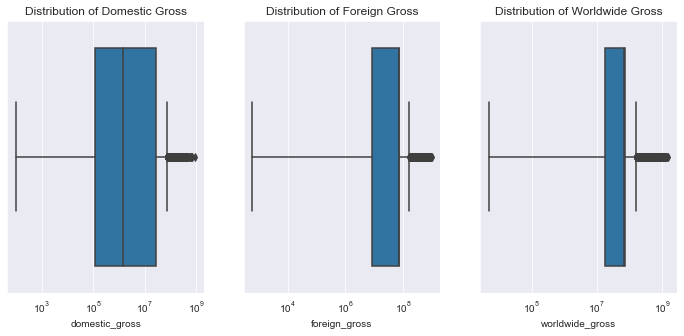

In [73]:
# creating the figure and axes
fig, axes = plt.subplots(ncols=3, figsize=(12, 5))

# set the style
sns.set_style('whitegrid')

# plot distribution for domestic gross
sns.boxplot(
    data=bom_df,
    x='domestic_gross',
    ax=axes[0]
)



# plot distribution for foreign gross
sns.boxplot(
    data=bom_df,
    x='foreign_gross',
    ax=axes[1]
)



# plot distribution for worldwide gross
sns.boxplot(
    data=bom_df,
    x='worldwide_gross',
    ax=axes[2]
)

# setting scale to log
axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')


# Labelling
axes[0].set_title('Distribution of Domestic Gross')
axes[1].set_title('Distribution of Foreign Gross')
axes[2].set_title('Distribution of Worldwide Gross');

### (c). Studios with highest Earnings

In [74]:
len(bom_df.studio.value_counts())

258

There are 257 Studios asociated with the movies. We get the studios with the highest earnings (worldwide gross)

In [75]:
# Get total earnings for each studio
total_studio_earnings = bom_df.groupby(
    'studio'
)['worldwide_gross'].sum()

# sorting the studios according to earnings
total_studio_earnings.sort_values(
    ascending=False,
    inplace=True
)

# get top 10 studios according to earnings
top_10_studios = total_studio_earnings[:10].reset_index()
top_10_studios

,studio,worldwide_gross
0,BV,44213702543
1,WB,31412801305
2,Fox,31020580426
3,Uni.,29967617711
4,Sony,22685523789
5,Par.,19924826363
6,WB (NL),10334796287
7,LGF,9215987696
8,IFC,6693197233
9,Magn.,5972688551


**Plot of the Top 10 Studio Earnings**

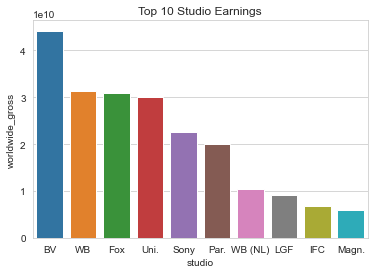

In [76]:
# bar plot of studio earnings
barplot = sns.barplot(
    data=top_10_studios,
    x='studio',
    y='worldwide_gross'
)
# labelling
barplot.set_title('Top 10 Studio Earnings');

Some of the top 10 earning studios include:
- BV studios
- Warner Bros studios
- Fox Studios
- universal studios
- Sony
- Paramount 
- Warner Bros. (New Line)
- Lionsgate Films (LGF)
- Independent Film Channel (IFC)
- Magnolia Pictures

### (d). Distribution of earnings over the years

In [77]:
# Creating grouped df of earnings by the years
yearly_earnings = bom_df.groupby(
    'year'
)['worldwide_gross'].sum().reset_index()

Text(0.5, 1.0, 'Distribution of earnings over the years')

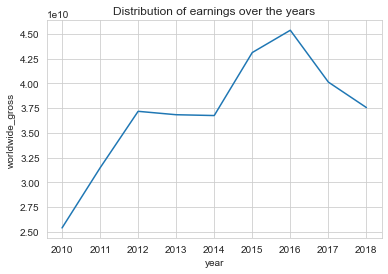

In [78]:
# Plotting the disribution over the years
ax = sns.lineplot(data=yearly_earnings, x='year', y='worldwide_gross')

# labelling
ax.set_title('Distribution of earnings over the years')

There has been an increased in revenue over the years.

Highest Earning is recorded in 2016 and has declined ever since. But the overall trend is positive, implying that the movie revenues are expected to rise moving foward, despite the recent decrease.

## 2. Best Ratings

We use the IMDB data to get some insights based on ratings.
- Best rated genres
- Best rated Writers
- Best rated Directors

### (a). Best rated genres

We use the genres df

In [79]:
# merge movie ratings and movie basics
genre_df.head()

,movie_id,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres
0,tt10356526,8,31,Laiye Je Yaarian,Laiye Je Yaarian,2019,117,Romance
1,tt10384606,9,559,Borderless,Borderless,2019,87,Documentary
2,tt1042974,6,20,Just Inès,Just Inès,2010,90,Drama
3,tt1043726,4,50352,The Legend of Hercules,The Legend of Hercules,2014,99,Action
3,tt1043726,4,50352,The Legend of Hercules,The Legend of Hercules,2014,99,Adventure


We start by grouping the data by the genre and getting the average rating

In [81]:
# grouping data by genre
genre_ratings = genre_df.groupby('genres')[['averagerating', 'numvotes']].mean() \
    .sort_values(ascending=False, by='averagerating')

# reset index
genre_ratings = genre_ratings.reset_index()

genre_ratings

,genres,averagerating,numvotes
0,Short,9,8
1,Documentary,7,267
2,Game-Show,7,1734
3,News,7,213
4,Biography,7,5673
5,Music,7,2771
6,History,7,2776
7,Sport,7,3186
8,War,7,3147
9,Reality-TV,7,27


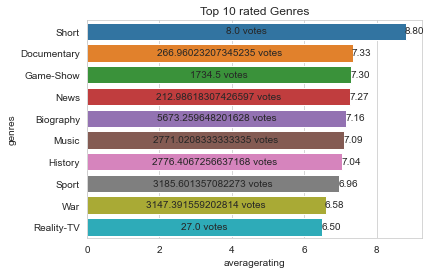

In [83]:
# creating figure and axis
fig, ax = plt.subplots()

# plotting the bar plot
sns.barplot(
    data=genre_ratings[:10],
    y='genres',
    x='averagerating',
    ax=ax,
    orient='h'
)
i = 0
votes = genre_ratings[:10].numvotes
# Labelling the number of votes and including the ratings
for p in ax.patches:
    # labelling the ratings
    ax.annotate(
        f'{p.get_width():.2f}',
        (p.get_width() + .25, p.get_y() + p.get_height()),
        ha='center', va='center',
        xytext=(0, 9),
        textcoords='offset points'
    )
    # labelling the number of votes
    ax.annotate(
        f'{votes[i]} votes',
        (p.get_width() / 2., p.get_y() + p.get_height()),
        ha='center', va='center',
        xytext=(0, 9),
        textcoords='offset points'
    )
    i += 1
    
# labelling the title
ax.set_title('Top 10 rated Genres');

The bar graph displays the top ten genres based on user ratings, with genres on the x-axis and ratings on the y-axis. The height of each bar represents the average rating for a particular genre, and the bars are color-coded for easy distinction. Additionally, the number of votes for each genre is taken into account to refine the ranking and differentiate between genres with similar ratings.

### (b.) Best rated Directors

The best directors are the ones with highly-rated movies.

merge the ratings and directors tables

In [84]:
director_ratings = directors.merge(
    movie_ratings,
    on='movie_id',
    how='inner'
)
director_ratings.head()

,movie_id,person_id,primary_name,birth_year,death_year,primary_profession,averagerating,numvotes
0,tt0285252,nm0899854,Tony Vitale,1964,0,"producer,director,writer",4,219
1,tt0462036,nm1940585,Bill Haley,0,0,"director,writer,producer",6,18
2,tt0835418,nm0151540,Jay Chandrasekhar,1968,0,"director,actor,writer",5,8147
3,tt0878654,nm0089502,Albert Pyun,1954,0,"director,writer,producer",6,875
4,tt0878654,nm2291498,Joe Baile,0,0,"producer,director,camera_department",6,875


Apply filter to exclude the deceased directors.

In [85]:

director_ratings = director_ratings.loc[
    director_ratings.death_year == 0
]

director_ratings.death_year.value_counts()

0    85331
Name: death_year, dtype: int64

Get the number of movies each director has featured in.

In [86]:

director_movie_count = director_ratings.groupby(
    ['person_id']
).size().sort_values(ascending=False)

# resetting the index and naming count column
director_movie_count = director_movie_count.reset_index(name='moviecount')

print('Highest movie count:', director_movie_count.moviecount.iloc[0])
print('Lowest movie count:', director_movie_count.moviecount.iloc[-1])

director_movie_count.head()

Highest movie count: 39
Lowest movie count: 1


,person_id,moviecount
0,nm5954636,39
1,nm2551464,37
2,nm3583561,34
3,nm4341114,31
4,nm2563700,30


Directors with a range of experience levels are included in the statistics; some have directed over 200 films, while others have just helmed one. We make a new column and classify their experience using the following categories:





* **Beginner**: 1-3 movies
* **Intermediate**: 4-5 movies
* **Experienced**: 6-15 movies
* **Highly Experienced**: 16-20 movies
* **Veteran**: 20+ movies

In [88]:
# function to categorize the experience
def set_experience(val):
    if val <= 3:
        return 'beginner'
    elif val > 3 and val <= 5:
        return 'intermediate'
    elif val > 5 and val <= 15:
        return 'experienced'
    elif val > 15 and val <=20:
        return 'highly experienced'
    else:
        return 'veteran'

experience column

In [89]:
director_movie_count['experience'] = director_movie_count.moviecount.map(
    lambda x: set_experience(x)
)
director_movie_count.head()


,person_id,moviecount,experience
0,nm5954636,39,veteran
1,nm2551464,37,veteran
2,nm3583561,34,veteran
3,nm4341114,31,veteran
4,nm2563700,30,veteran


The average number of votes and the average rating of each director's film are then determined by grouping the data by director. This makes it possible for us to evaluate each director's work in light of the reviews and box office success of each of their films.



In [90]:
# grouping by the directiors
ratings_by_directors = director_ratings.groupby(
    ['person_id', 'primary_name']
)[
    ['averagerating', 'numvotes']
].mean()

# reseting the index
ratings_by_directors.reset_index(inplace=True)


ratings_by_directors.head()

,person_id,primary_name,averagerating,numvotes
0,nm0000095,Woody Allen,7,106068
1,nm0000108,Luc Besson,6,113490
2,nm0000110,Kenneth Branagh,7,160111
3,nm0000118,John Carpenter,6,38287
4,nm0000123,George Clooney,6,118783


Next, we group the data by director to find the average number of votes and rating for each director's film. This allows us to analyse each director's output based on the evaluations and box office performance of their individual productions. The average number of votes is then converted to an integer, and the average rating is rounded to one decimal place.

In [91]:
# rounding the ratings column
ratings_by_directors.averagerating = ratings_by_directors.averagerating.round(1)

# convert votes to integers
ratings_by_directors.numvotes = ratings_by_directors.numvotes.astype(int)

# sorting
ratings_by_directors.sort_values(
    by=['averagerating', 'numvotes'],
    ascending=False,
    inplace=True
)

ratings_by_directors

,person_id,primary_name,averagerating,numvotes
31643,nm3388005,Stephen Peek,10,20
51014,nm7223265,Loreto Di Cesare,10,8
52109,nm7633303,Lindsay Thompson,10,7
50148,nm6925060,Tristan David Luciotti,10,6
54795,nm8791543,Emre Oran,10,6
...,...,...,...,...
54832,nm8809512,Erik Alarik,1,8
23645,nm2277264,Koki Ebata,1,7
40737,nm4728793,Takeo Urakami,1,7
28377,nm2947112,Shinju Funabiki,1,6


It appears that the top directors have an average rating of 10, while the lowest have an average rating of 1. Since this has a major impact on the director's grade, we also consider the total number of films in which each filmmaker has starred.


In [92]:
# merging the ratings to include movies count
ratings_by_directors = ratings_by_directors.merge(
    director_movie_count,
    on='person_id',
    how='inner'
)
 
ratings_by_directors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56784 entries, 0 to 56783
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   person_id      56784 non-null  object 
 1   primary_name   56784 non-null  object 
 2   averagerating  56784 non-null  float64
 3   numvotes       56784 non-null  int32  
 4   moviecount     56784 non-null  int64  
 5   experience     56784 non-null  object 
dtypes: float64(1), int32(1), int64(1), object(3)
memory usage: 2.8+ MB


In [93]:
# change data type of moviecount column
ratings_by_directors.moviecount = ratings_by_directors.moviecount.astype('Int32')
# include sorting by movie count
ratings_by_directors.sort_values(
    by=['averagerating', 'moviecount', 'numvotes'],
    ascending=False,
    inplace=True
)

ratings_by_directors

,person_id,primary_name,averagerating,numvotes,moviecount,experience
0,nm3388005,Stephen Peek,10,20,1,beginner
1,nm7223265,Loreto Di Cesare,10,8,1,beginner
2,nm7633303,Lindsay Thompson,10,7,1,beginner
3,nm6925060,Tristan David Luciotti,10,6,1,beginner
4,nm8791543,Emre Oran,10,6,1,beginner
...,...,...,...,...,...,...
56779,nm8809512,Erik Alarik,1,8,1,beginner
56780,nm2277264,Koki Ebata,1,7,1,beginner
56781,nm4728793,Takeo Urakami,1,7,1,beginner
56782,nm2947112,Shinju Funabiki,1,6,1,beginner


let us group the directors based on experience and compare them

In [94]:
# top 5 beginner ditectors
top_5_beginner_directors = ratings_by_directors.loc[
    ratings_by_directors.experience == 'beginner'
][:5]

# top 5 intermediate ditectors
top_5_intermediate_directors = ratings_by_directors.loc[
    ratings_by_directors.experience == 'intermediate'
][:5]

# top 5 experienced ditectors
top_5_experienced_directors = ratings_by_directors.loc[
    ratings_by_directors.experience == 'experienced'
][:5]

# top 5 highly experienced ditectors
top_5_highly_directors = ratings_by_directors.loc[
    ratings_by_directors.experience == 'highly experienced'
][:5]

# top 5 veteran ditectors
top_5_veteran_directors= ratings_by_directors.loc[
    ratings_by_directors.experience == 'veteran'
][:5]

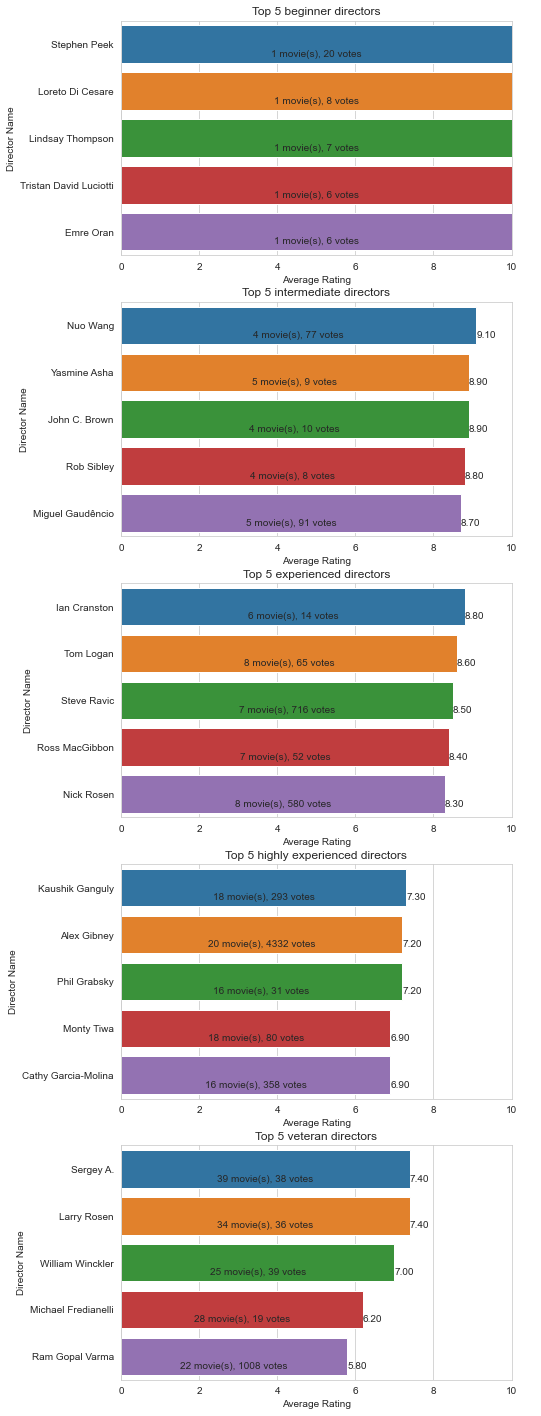

In [97]:
# create figure and axes
fig, axes = plt.subplots(nrows=5, figsize=(7, 25))

# list of all dataframes
data_list = [
    top_5_beginner_directors,
    top_5_intermediate_directors,
    top_5_experienced_directors,
    top_5_highly_directors,
    top_5_veteran_directors
]
# plotting the data
for i, data in enumerate(data_list):
    sns.barplot(
        data=data,
        x='averagerating',
        y='primary_name',
        ax=axes[i]
    )
    # including the number of votes and movie count
    n = 0
    for p in axes[i].patches:
        # labelling the rating
        axes[i].annotate(
            f'{p.get_width():.2f}',
            (p.get_width() + .25, p.get_y() + p.get_height()),
            ha='center', va='center',
            xytext=(0, 9),
            textcoords='offset points'
        )
        # labelling the number of votes
        axes[i].annotate(
            f'{data.moviecount.iloc[n]} movie(s), {data.numvotes.iloc[n]} votes',
            (p.get_width() / 2., p.get_y() + p.get_height()),
            ha='center', va='center',
            xytext=(0, 9),
            textcoords='offset points'
        )
        n += 1
    
    # labeling axes
    axes[i].set_title(f'Top 5 {data.experience.iloc[i]} directors')
    axes[i].set_xlabel('Average Rating')
    axes[i].set_ylabel('Director Name')
    axes[i].set_xlim(0, 10)

In [98]:
# print top director in each experience category
print('Top Director in each experience category:')
print('Beginner:', top_5_beginner_directors.primary_name.iloc[0])
print('Intermediate:', top_5_intermediate_directors.primary_name.iloc[0])
print('Experienced:', top_5_experienced_directors.primary_name.iloc[0])
print('Highly Experienced:', top_5_highly_directors.primary_name.iloc[0])
print('Veteran:', top_5_veteran_directors.primary_name.iloc[0])

Top Director in each experience category:
Beginner: Stephen Peek
Intermediate: Nuo Wang
Experienced: Ian Cranston
Highly Experienced: Kaushik Ganguly
Veteran: Sergey A.


The top directors are shown in the graphs above according to their experience levels and movie ratings.

Various factors can vary based on the directors' experience, such as:


* **Salary**
* **Quality of Movies**
* **Audience Reception**
* **Production Budgets**

While inexperienced filmmakers may be paid less and have less resources, as they get more experience, they typically make better films, get better reviews from critics, and are paid more. Experienced filmmakers with a wealth of knowledge frequently have a solid reputation, which helps them draw top talent and achieve bigger budgets, thus improving the calibre and commercial success of their films.

It's interesting to consider that beginners sometimes receive higher scores. This is caused by the effect of directing a limited number of films, which could lead to a tiny sample size biassing the ratings. Their average rating can be significantly improved by a single popular film. Directors' ratings may promote and offer a broader overview of their work as their scope of work and previous experience expand.

(c). Best Rated writers


i. Merge writers and ratings table

In [100]:
# merging writers and movie ratings
writer_ratings = writers.merge(
    movie_ratings,
    on='movie_id',
    how='inner'
)
writer_ratings.head()

,movie_id,person_id,primary_name,birth_year,death_year,primary_profession,averagerating,numvotes
0,tt0285252,nm0899854,Tony Vitale,1964,0,"producer,director,writer",4,219
1,tt0462036,nm1940585,Bill Haley,0,0,"director,writer,producer",6,18
2,tt0835418,nm0310087,Peter Gaulke,0,0,"writer,actor,director",5,8147
3,tt0835418,nm0841532,Gerry Swallow,0,0,"writer,actor,miscellaneous",5,8147
4,tt0878654,nm0284943,Randall Fontana,0,0,"writer,director,actor",6,875



ii. Exclude deceased writers

In [102]:
writer_ratings = writer_ratings.loc[
    writer_ratings.death_year == 0
]

# check the death year collumn
writer_ratings.death_year.value_counts()

0    109319
Name: death_year, dtype: int64


iii. Get movies count for each writer

In [103]:
writer_movie_count = writer_ratings.groupby(
    ['person_id']
).size().sort_values(ascending=False)

# resetting the index and naming count column
writer_movie_count = writer_movie_count.reset_index(name='moviecount')

# Creating the experience column
writer_movie_count['experience'] = writer_movie_count.moviecount.map(
    lambda x: set_experience(x)
)

print('Highest movie count:', writer_movie_count.moviecount.iloc[0])
print('Lowest movie count:', writer_movie_count.moviecount.iloc[-1])

writer_movie_count.head()

Highest movie count: 40
Lowest movie count: 1


,person_id,moviecount,experience
0,nm5954636,40,veteran
1,nm3057599,32,veteran
2,nm3583561,32,veteran
3,nm0893128,32,veteran
4,nm0598531,32,veteran



iv. Getting average ratings of each writer

In [104]:

# grouping by the writers
ratings_by_writers = writer_ratings.groupby(
    ['person_id', 'primary_name']
)[
    ['averagerating', 'numvotes']
].mean()

# reseting the index
ratings_by_writers.reset_index(inplace=True)


ratings_by_writers.head()

,person_id,primary_name,averagerating,numvotes
0,nm0000092,John Cleese,7,89365
1,nm0000095,Woody Allen,7,106068
2,nm0000101,Dan Aykroyd,5,186788
3,nm0000108,Luc Besson,6,87080
4,nm0000116,James Cameron,7,161411


round the ratings to one decimal point and convert the votes to integer values.

In [105]:
# rounding the ratings column
ratings_by_writers.averagerating = ratings_by_writers.averagerating.round(
    1)

# convert votes to integers
ratings_by_writers.numvotes = ratings_by_writers.numvotes.astype(int)

# sorting
ratings_by_writers.sort_values(
    by=['averagerating', 'numvotes'],
    ascending=False,
    inplace=True
)

ratings_by_writers

,person_id,primary_name,averagerating,numvotes
63710,nm6680574,Brian Baucum,10,8
66116,nm7223265,Loreto Di Cesare,10,8
67762,nm7633303,Lindsay Thompson,10,7
71714,nm8791543,Emre Oran,10,6
15236,nm10616933,Ivana Diniz,10,5
...,...,...,...,...
71763,nm8809512,Erik Alarik,1,8
34829,nm2947112,Shinju Funabiki,1,6
60173,nm6008960,Eva Toulová,1,5
74437,nm9854007,Giueppe di Giorgio,1,5



We then include the movie count and experience by merging with the movie count df.

In [106]:
# merging the ratings to include movies count
ratings_by_writers = ratings_by_writers.merge(
    writer_movie_count,
    on='person_id',
    how='inner'
)

ratings_by_writers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74705 entries, 0 to 74704
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   person_id      74705 non-null  object 
 1   primary_name   74705 non-null  object 
 2   averagerating  74705 non-null  float64
 3   numvotes       74705 non-null  int32  
 4   moviecount     74705 non-null  int64  
 5   experience     74705 non-null  object 
dtypes: float64(1), int32(1), int64(1), object(3)
memory usage: 3.7+ MB



We then sort the records according to the rating, then movie count and finally the number of votes.

In [107]:
# change data type of moviecount column
ratings_by_writers.moviecount = ratings_by_writers.moviecount.astype(
    'Int32')
# include sorting by movie count
ratings_by_writers.sort_values(
    by=['averagerating', 'moviecount', 'numvotes'],
    ascending=False,
    inplace=True
)

ratings_by_writers

,person_id,primary_name,averagerating,numvotes,moviecount,experience
0,nm6680574,Brian Baucum,10,8,1,beginner
1,nm7223265,Loreto Di Cesare,10,8,1,beginner
2,nm7633303,Lindsay Thompson,10,7,1,beginner
3,nm8791543,Emre Oran,10,6,1,beginner
4,nm10616933,Ivana Diniz,10,5,1,beginner
...,...,...,...,...,...,...
74700,nm8809512,Erik Alarik,1,8,1,beginner
74701,nm2947112,Shinju Funabiki,1,6,1,beginner
74702,nm6008960,Eva Toulová,1,5,1,beginner
74703,nm9854007,Giueppe di Giorgio,1,5,1,beginner


v. Grouping according to experience